In [2]:
import scipy.io as sio
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from pyspark.sql.functions import *
from pandas.plotting import register_matplotlib_converters

In [3]:
def import_file():       
    all_data = pd.DataFrame()
    path = "E:\\Cerin_big-data\\"
    files = ["Test-Jan-01-Jan-05.xlsx", "Test-Jul-01-Jul-05.xlsx"]
    #files = ["CERIn-Big-Data-2018-01-01-to-2018-07-01-Values.xlsx"]
    for f in files:
        full_path = path + f
        print(full_path)
        column_list = {'Phase A Current','Phase B Current','Phase C Current','Current Total','Power Factor',
                      'Frequency','Apparent Power','Active Power','Reactive Power','Power Production',
                       'Phase AB Voltage','Phase BC Voltage','Phase CA Voltage'}
        converters = {col: float for col in column_list}
        na_values=['I/O Timeout','Invalid Data']
        df = pd.read_excel(full_path,header=0, na_values=na_values, thousands=".", decimal=",")
        all_data = all_data.append(df,ignore_index=True)
    
    return all_data

In [4]:
def show_info(column, percentil, last_size , current_size):
    print("Column: {:>7} \t Percentile: {:>18} \t Bef/Actual/Del: {:>8} / {:>8} / {:>5}"
        .format(column, percentil, last_size, current_size, last_size - current_size))

In [17]:
def filter_data_by_date(dataset, start_date_time, end_date_time):
    return dataset[(dataset['Data'] >= start_date_time) & (filtered['Data'] < end_date_time)]

In [16]:
def filter_data_by_percentil(dataset):
    last_size = len(dataset)
    colums = [k for k in list(dataset) if 'data' not in k.lower()]
    for column in colums:
        #dataset = dataset[pd.to_numeric(dataset[column], errors='coerce').notnull()]
        percentil = np.nanpercentile(dataset[column],1, interpolation='lower')
        
        ################# GOSTARIA DE UMA ATENÇÃO MAIOR AQUI, POIS NÃO SEI SE ESTÁ CORRETO ESSE TIPO DE 
        ################# VERIFICAÇÃO "> QUE".
        dataset = dataset[dataset[column] > percentil]
        
        current_size = len(dataset[column])
        show_info(column, percentil, last_size, current_size)        
        last_size = current_size
    return dataset	

In [6]:
def write_to_csv():
    path = "E://Cerin_big-data//dataframe3.csv"
    df.coalesce(1).write.format("com.databricks.spark.csv").option("header", "true").option("thousands", ".").option("decimal", ",").save(path)

In [35]:
def get_configured_graph(xaxis_label, yaxis_label, title):
    register_matplotlib_converters()
   
    fig, ax = plt.subplots(1)
    fig.autofmt_xdate()
    
    fig.suptitle(title, fontsize=20)
    plt.xlabel(xaxis_label, fontsize=18)
    plt.ylabel(yaxis_label, fontsize=16)
    
    xfmt = mdates.DateFormatter('%d-%m-%y %H:%M')
    ax.xaxis.set_major_formatter(xfmt)

    return plt    

In [48]:
def set_data_and_show_graph(data, plot, fields):
    plot.plot(data['Data'], data[fields[0]], 'r--',
              data['Data'], data[fields[1]], 'g--',
              data['Data'], data[fields[2]], 'b--')
    plot.legend()
    plot.show()

In [ ]:
data = import_file()
data.info()
data.head()

In [ ]:
filtered = filter_data_by_percentil(data)
filtered.info()
filtered.head()

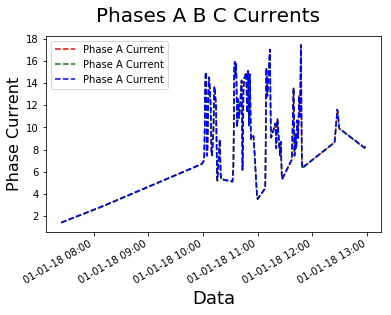

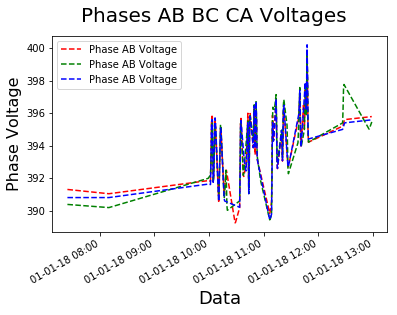

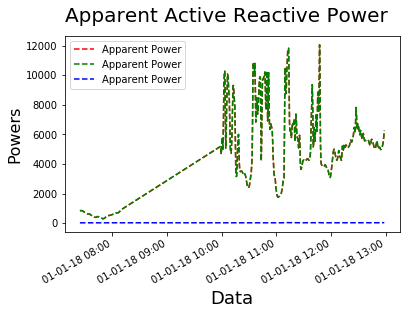

In [49]:
start_date_time = '2018-01-01 00:00:00'
end_date_time = '2018-01-02 00:00:00'

data_filtered = filter_data_by_date(filtered, start_date_time, end_date_time)

fields = ['Phase A Current','Phase B Current','Phase C Current','Current Total',
          'Phase AB Voltage','Phase BC Voltage','Phase CA Voltage',
          'Apparent Power','Active Power','Reactive Power']

plt1 = get_configured_graph('Data', 'Phase Current', 'Phases A B C Currents')
set_data_and_show_graph(data_filtered, plt1, ['Phase A Current', 'Phase B Current', 'Phase C Current'])

plt2 = get_configured_graph('Data', 'Phase Voltage', 'Phases AB BC CA Voltages')
set_data_and_show_graph(data_filtered, plt2, ['Phase AB Voltage', 'Phase BC Voltage', 'Phase CA Voltage'])

plt3 = get_configured_graph('Data', 'Powers', 'Apparent Active Reactive Power')
set_data_and_show_graph(data_filtered, plt3, ['Apparent Power', 'Active Power', 'Reactive Power'])

In [ ]:
df = spark.createDataFrame(filtered)

In [ ]:
df = df.select(df['*'], weekofyear('Data').alias('WeekOfYear'), date_format('Data', 'u').alias('DayOfWeek'))

In [ ]:
df.schema.fields

In [ ]:
report = df.select('WeekOfYear','DayOfWeek','Data','Power Production').groupBy("WeekOfYear",'DayOfWeek').agg(min("Data").alias('Start Date'), max("Data").alias('End Date'), min("Power Production").alias('Init PP'), max("Power Production").alias('Final PP'), (max("Power Production") -  min("Power Production")).alias('Total PP')).orderBy(asc("WeekOfYear"),asc("DayOfWeek"))
report.show()

In [ ]:
catalog_name = "ElectricalValues"
spark.catalog.dropTempView(catalog_name)
df.createOrReplaceTempView(catalog_name)
spark.catalog.listTables()

In [ ]:
write_to_csv()